# ESCMID AI Course - Day 2: Machine Learning for Antibiotic Resistance Prediction (Synthetic Data)

## Overview
This notebook demonstrates comprehensive machine learning approaches for predicting antibiotic resistance using synthetic microbiology data. We will cover:

1. **Data Loading and Exploration**
2. **Multi-target Prediction Strategies**
3. **Cross-Validation Techniques**
4. **Performance Metrics and Evaluation**
5. **Model Comparison and Selection**
6. **Feature Engineering for Microbiology Data**

### Learning Objectives
- Understand challenges in microbiology data analysis
- Learn to handle multi-class and multi-target problems
- Implement comprehensive model validation
- Compare different resistance mechanisms
- Interpret results in clinical microbiology context

### Dataset Description
The synthetic dataset contains:
- **Clinical metadata**: Study, Country, Gender, Age Group, Specialty, Source, Patient type, Year
- **Bacterial identification**: Species, Family
- **Antimicrobial susceptibility**: MIC values and interpretations for multiple antibiotics
- **Resistance mechanisms**: β-lactamase genes (ESBL, AmpC, Carbapenemase)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report, 
                           roc_curve, precision_recall_curve, multilabel_confusion_matrix)

# Model persistence
import joblib

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading and Exploration

Let's start by loading and understanding the synthetic microbiology dataset.

In [2]:
# Load the synthetic dataset
df = pd.read_csv('../../DAY_1/DATA/Synthetic_Data_cleaned.csv', 
                 low_memory=False)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.shape[1]}")
print(f"Samples: {df.shape[0]}")

# Display basic information about the dataset
print("\nColumn categories:")
print(f"- Clinical metadata: {['Study', 'Country', 'Gender', 'Age.Group', 'Speciality', 'Source', 'In...Out.Patient', 'Year']}")
print(f"- Bacterial identification: {['Species', 'Family', 'Phenotype']}")
print(f"- Antimicrobial data: MIC values and interpretations")
print(f"- Resistance genes: β-lactamase detection")

# Display first few rows
df.head(3)

Dataset shape: (9635, 132)
Columns: 132
Samples: 9635

Column categories:
- Clinical metadata: ['Study', 'Country', 'Gender', 'Age.Group', 'Speciality', 'Source', 'In...Out.Patient', 'Year']
- Bacterial identification: ['Species', 'Family', 'Phenotype']
- Antimicrobial data: MIC values and interpretations
- Resistance genes: β-lactamase detection


,Study,Species,Family,Country,Gender,Age.Group,Speciality,Source,In...Out.Patient,Year,...,DHA,FOX,ACTMIR,KPC,OXA,NDM,IMP,VIM,SPM,GIM
0,C,Staphylococcus aureus,Staphylococcus spp,Z1,Female,19 to 64 Years,Medicine ICU,Sputum,None Given,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,Haemophilus influenzae,Haemophilus spp,Z7,Female,85 and Over,Emergency Room,Sputum,Inpatient,2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,Klebsiella oxytoca,Enterobacteriaceae,Z3,Male,19 to 64 Years,Surgery General,Sputum,Inpatient,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Explore the key columns for our analysis
clinical_features = ['Species', 'Family', 'Country', 'Gender', 'Age.Group', 'Speciality', 'Source', 'In...Out.Patient', 'Year']

# Resistance mechanisms we'll predict
resistance_genes = ['KPC', 'NDM', 'OXA', 'SHV', 'TEM', 'CTXM1', 'CTXM2', 'CTXM825', 'CTXM9']

# Key antibiotics for interpretation columns
key_antibiotics = ['Ceftriaxone_I', 'Meropenem_I', 'Ciprofloxacin_I', 'Amikacin_I', 'Vancomycin_I']

print("Clinical Features Distribution:")
print("=" * 40)
for feature in ['Species', 'Family', 'Source', 'Gender']:
    if feature in df.columns:
        print(f"\n{feature}:")
        print(df[feature].value_counts().head())

print(f"\nResistance genes available: {resistance_genes}")
print(f"Key antibiotic interpretations: {key_antibiotics}")

# Check missing values in key columns
print("\nMissing values in key columns:")
missing_data = df[clinical_features + resistance_genes + key_antibiotics].isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
if len(missing_data) > 0:
    print(missing_data)
else:
    print("No missing values in selected columns")

Clinical Features Distribution:

Species:
Species
Escherichia coli           2073
Staphylococcus aureus      1087
Acinetobacter baumannii     958
Pseudomonas aeruginosa      793
Haemophilus influenzae      668
Name: count, dtype: int64

Family:
Family
Enterobacteriaceae          3223
Non-Enterobacteriaceae      1719
Staphylococcus spp          1373
Haemophilus spp              696
Streptococcus pneumoniae     527
Name: count, dtype: int64

Source:
Source
Blood                    1876
Wound                    1374
Sputum                   1307
Urine                    1233
Endotracheal aspirate     424
Name: count, dtype: int64

Gender:
Gender
Male      5173
Female    4462
Name: count, dtype: int64

Resistance genes available: ['KPC', 'NDM', 'OXA', 'SHV', 'TEM', 'CTXM1', 'CTXM2', 'CTXM825', 'CTXM9']
Key antibiotic interpretations: ['Ceftriaxone_I', 'Meropenem_I', 'Ciprofloxacin_I', 'Amikacin_I', 'Vancomycin_I']

Missing values in key columns:
CTXM9              9161
CTXM825            9

## 2. Understanding Microbiology Data Challenges

Microbiology data presents unique challenges:

### Data Characteristics
- **High dimensionality**: Many antibiotics tested
- **Missing values**: Not all antibiotics tested for all isolates
- **Class imbalance**: Resistance mechanisms are often rare
- **Multi-target prediction**: Multiple resistance genes to predict
- **Categorical features**: Species, source, demographics

### Clinical Relevance
- **ESBL genes (SHV, TEM, CTX-M)**: Confer resistance to extended-spectrum β-lactams
- **Carbapenemase genes (KPC, NDM, OXA)**: Confer resistance to carbapenems (last-resort antibiotics)
- **Species specificity**: Different mechanisms predominate in different species

Data Preprocessing for Machine Learning
KPC: 46 positive / 9635 total (0.48%)
NDM: 29 positive / 9635 total (0.30%)
OXA: 38 positive / 9635 total (0.39%)
SHV: 207 positive / 9635 total (2.15%)
TEM: 264 positive / 9635 total (2.74%)
CTXM1: 317 positive / 9635 total (3.29%)
CTXM2: 32 positive / 9635 total (0.33%)
CTXM825: 24 positive / 9635 total (0.25%)
CTXM9: 54 positive / 9635 total (0.56%)

Feature matrix shape: (9635, 8)
Features: ['Species', 'Family', 'Country', 'Gender', 'Age.Group', 'Speciality', 'Source', 'Year']

Target matrix shape: (9635, 9)
Genes to predict: ['KPC', 'NDM', 'OXA', 'SHV', 'TEM', 'CTXM1', 'CTXM2', 'CTXM825', 'CTXM9']

Correlation between resistance genes:


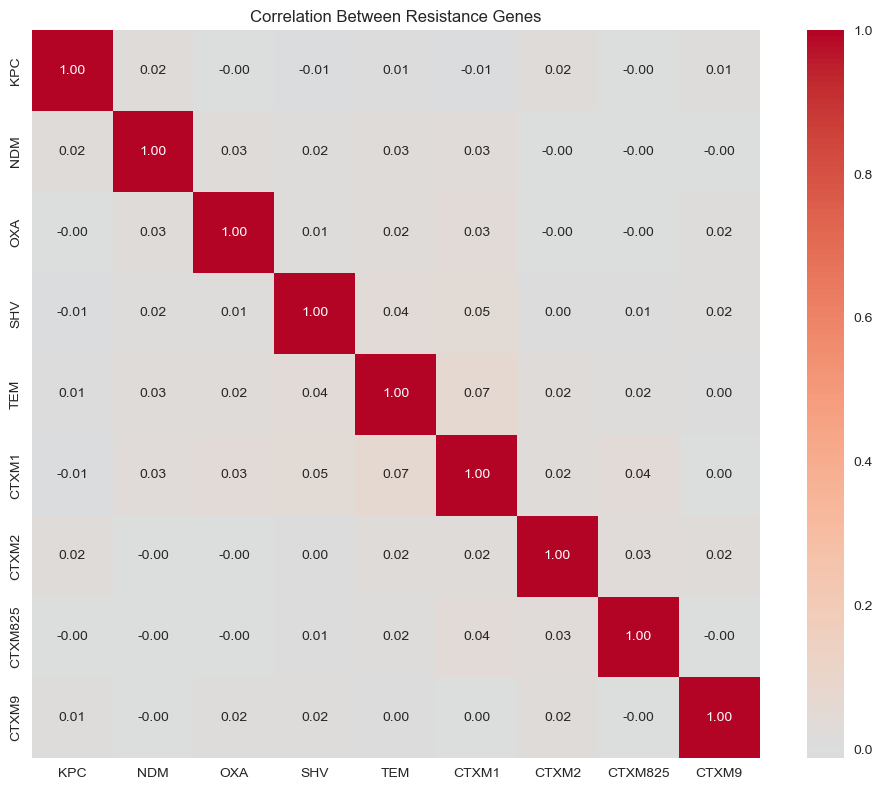

In [4]:
# Data preprocessing for machine learning
print("Data Preprocessing for Machine Learning")
print("=" * 50)

# 1. Create binary targets for resistance genes
resistance_targets = {}
for gene in resistance_genes:
    if gene in df.columns:
        # Convert to binary (positive detection vs negative/missing)
        resistance_targets[gene] = (df[gene].notna() & (df[gene] != 'NEG')).astype(int)
        print(f"{gene}: {resistance_targets[gene].sum()} positive / {len(resistance_targets[gene])} total ({resistance_targets[gene].mean():.2%})")

# 2. Prepare feature matrix
# Select clinical features for prediction
feature_columns = ['Species', 'Family', 'Country', 'Gender', 'Age.Group', 'Speciality', 'Source', 'Year']

# Create feature dataframe
X_raw = df[feature_columns].copy()

# Handle missing values in categorical columns
for col in feature_columns:
    if X_raw[col].dtype == 'object':
        X_raw[col] = X_raw[col].fillna('Unknown')

print(f"\nFeature matrix shape: {X_raw.shape}")
print(f"Features: {feature_columns}")

# 3. Create target matrix for multi-target prediction
available_genes = [gene for gene in resistance_genes if gene in resistance_targets]
y_multi = pd.DataFrame(resistance_targets)[available_genes]

print(f"\nTarget matrix shape: {y_multi.shape}")
print(f"Genes to predict: {available_genes}")

# Display correlation between targets
print("\nCorrelation between resistance genes:")
correlation_matrix = y_multi.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Between Resistance Genes')
plt.tight_layout()
plt.show()

## 3. Single-Target vs Multi-Target Prediction

We'll compare two approaches:

### Single-Target Approach
- Train separate models for each resistance gene
- Allows optimization for each specific gene
- Independent predictions

### Multi-Target Approach  
- Train one model to predict all genes simultaneously
- Captures correlations between genes
- More efficient for deployment

In [5]:
# Set up preprocessing pipeline
categorical_features = ['Species', 'Family', 'Country', 'Gender', 'Age.Group', 'Speciality', 'Source']
numerical_features = ['Year']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Initialize models for comparison
base_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(class_weight='balanced', random_state=42, probability=True),
    'Naive Bayes': GaussianNB()
}

print("Models and preprocessing pipeline prepared")
print(f"Categorical features: {len(categorical_features)}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Base models: {list(base_models.keys())}")

Models and preprocessing pipeline prepared
Categorical features: 7
Numerical features: 1
Base models: ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'SVM', 'Naive Bayes']


In [6]:
# Single-target approach: Focus on most prevalent genes
prevalent_genes = []
for gene in available_genes:
    prevalence = y_multi[gene].mean()
    if prevalence > 0.05:  # At least 5% prevalence
        prevalent_genes.append(gene)

print(f"Genes with >5% prevalence: {prevalent_genes}")

if not prevalent_genes:
    # If no genes meet threshold, select top 3 most prevalent
    prevalences = y_multi.mean().sort_values(ascending=False)
    prevalent_genes = prevalences.head(3).index.tolist()
    print(f"Top 3 most prevalent genes: {prevalent_genes}")

# Perform single-target cross-validation
single_target_results = {}
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"\nPerforming single-target cross-validation for {len(prevalent_genes)} genes...")
print("-" * 80)

for gene in prevalent_genes:
    print(f"\nAnalyzing {gene} (prevalence: {y_multi[gene].mean():.2%})")
    print("-" * 40)
    
    gene_results = {}
    y_gene = y_multi[gene]
    
    # Skip if too few positive cases
    if y_gene.sum() < 10:
        print(f"Skipping {gene}: too few positive cases ({y_gene.sum()})")
        continue
    
    for model_name, base_model in base_models.items():
        try:
            # Create pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', base_model)
            ])
            
            # Perform cross-validation
            cv_scores = cross_val_score(pipeline, X_raw, y_gene, cv=skf, scoring='roc_auc')
            gene_results[model_name] = {
                'mean_auc': cv_scores.mean(),
                'std_auc': cv_scores.std(),
                'scores': cv_scores
            }
            
            print(f"{model_name:20s} | AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
            
        except Exception as e:
            print(f"{model_name:20s} | Error: {str(e)[:50]}")
            continue
    
    single_target_results[gene] = gene_results

Genes with >5% prevalence: []
Top 3 most prevalent genes: ['CTXM1', 'TEM', 'SHV']

Performing single-target cross-validation for 3 genes...
--------------------------------------------------------------------------------

Analyzing CTXM1 (prevalence: 3.29%)
----------------------------------------
Logistic Regression  | AUC: 0.718 ± 0.029
Random Forest        | AUC: 0.650 ± 0.041
Gradient Boosting    | AUC: 0.777 ± 0.019
SVM                  | AUC: 0.725 ± 0.031
Naive Bayes          | AUC: 0.521 ± 0.010

Analyzing TEM (prevalence: 2.74%)
----------------------------------------
Logistic Regression  | AUC: 0.686 ± 0.043
Random Forest        | AUC: 0.625 ± 0.016
Gradient Boosting    | AUC: 0.730 ± 0.028
SVM                  | AUC: 0.693 ± 0.029
Naive Bayes          | AUC: 0.559 ± 0.012

Analyzing SHV (prevalence: 2.15%)
----------------------------------------
Logistic Regression  | AUC: 0.686 ± 0.019
Random Forest        | AUC: 0.624 ± 0.062
Gradient Boosting    | AUC: 0.734 ± 0.020
SVM

## 4. Multi-Target Learning Approach

Multi-target learning can capture dependencies between resistance genes and provide more efficient prediction.

In [7]:
# Multi-target approach
print("Multi-Target Learning Approach")
print("=" * 40)

# Select genes for multi-target prediction (only those with sufficient data)
multi_target_genes = []
for gene in prevalent_genes:
    if gene in single_target_results and len(single_target_results[gene]) > 0:
        multi_target_genes.append(gene)

print(f"Genes for multi-target prediction: {multi_target_genes}")

if len(multi_target_genes) >= 2:
    y_multi_subset = y_multi[multi_target_genes]
    
    # Multi-target models
    multi_target_models = {}
    for model_name, base_model in base_models.items():
        try:
            # Create multi-output pipeline
            multi_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', MultiOutputClassifier(base_model))
            ])
            multi_target_models[model_name] = multi_pipeline
        except Exception as e:
            print(f"Could not create multi-target model for {model_name}: {e}")
            continue
    
    # Cross-validation for multi-target models
    print(f"\nMulti-target cross-validation results:")
    print("-" * 50)
    
    multi_target_results = {}
    
    for model_name, pipeline in multi_target_models.items():
        try:
            # For multi-target, we'll compute average AUC across all targets
            fold_aucs = []
            
            for train_idx, val_idx in skf.split(X_raw, y_multi_subset.iloc[:, 0]):  # Use first target for stratification
                X_train_fold = X_raw.iloc[train_idx]
                X_val_fold = X_raw.iloc[val_idx]
                y_train_fold = y_multi_subset.iloc[train_idx]
                y_val_fold = y_multi_subset.iloc[val_idx]
                
                # Train model
                pipeline.fit(X_train_fold, y_train_fold)
                
                # Predict probabilities
                y_pred_proba = pipeline.predict_proba(X_val_fold)
                
                # Calculate AUC for each target
                fold_target_aucs = []
                for i, gene in enumerate(multi_target_genes):
                    if len(np.unique(y_val_fold.iloc[:, i])) > 1:  # Need both classes
                        # Extract probabilities for positive class
                        if hasattr(y_pred_proba[i], 'shape') and len(y_pred_proba[i].shape) > 1:
                            proba_pos = y_pred_proba[i][:, 1]
                        else:
                            proba_pos = y_pred_proba[i]
                        
                        auc = roc_auc_score(y_val_fold.iloc[:, i], proba_pos)
                        fold_target_aucs.append(auc)
                
                if fold_target_aucs:
                    fold_aucs.append(np.mean(fold_target_aucs))
            
            if fold_aucs:
                multi_target_results[model_name] = {
                    'mean_auc': np.mean(fold_aucs),
                    'std_auc': np.std(fold_aucs),
                    'scores': fold_aucs
                }
                
                print(f"{model_name:20s} | Avg AUC: {np.mean(fold_aucs):.3f} ± {np.std(fold_aucs):.3f}")
            
        except Exception as e:
            print(f"{model_name:20s} | Error: {str(e)[:50]}")
            continue

else:
    print("Not enough genes with sufficient data for multi-target learning")
    multi_target_results = {}

Multi-Target Learning Approach
Genes for multi-target prediction: ['CTXM1', 'TEM', 'SHV']

Multi-target cross-validation results:
--------------------------------------------------
Logistic Regression  | Avg AUC: 0.708 ± 0.021
Random Forest        | Avg AUC: 0.639 ± 0.021
Gradient Boosting    | Avg AUC: 0.756 ± 0.009
SVM                  | Avg AUC: 0.710 ± 0.017
Naive Bayes          | Avg AUC: 0.551 ± 0.007


Results Visualization


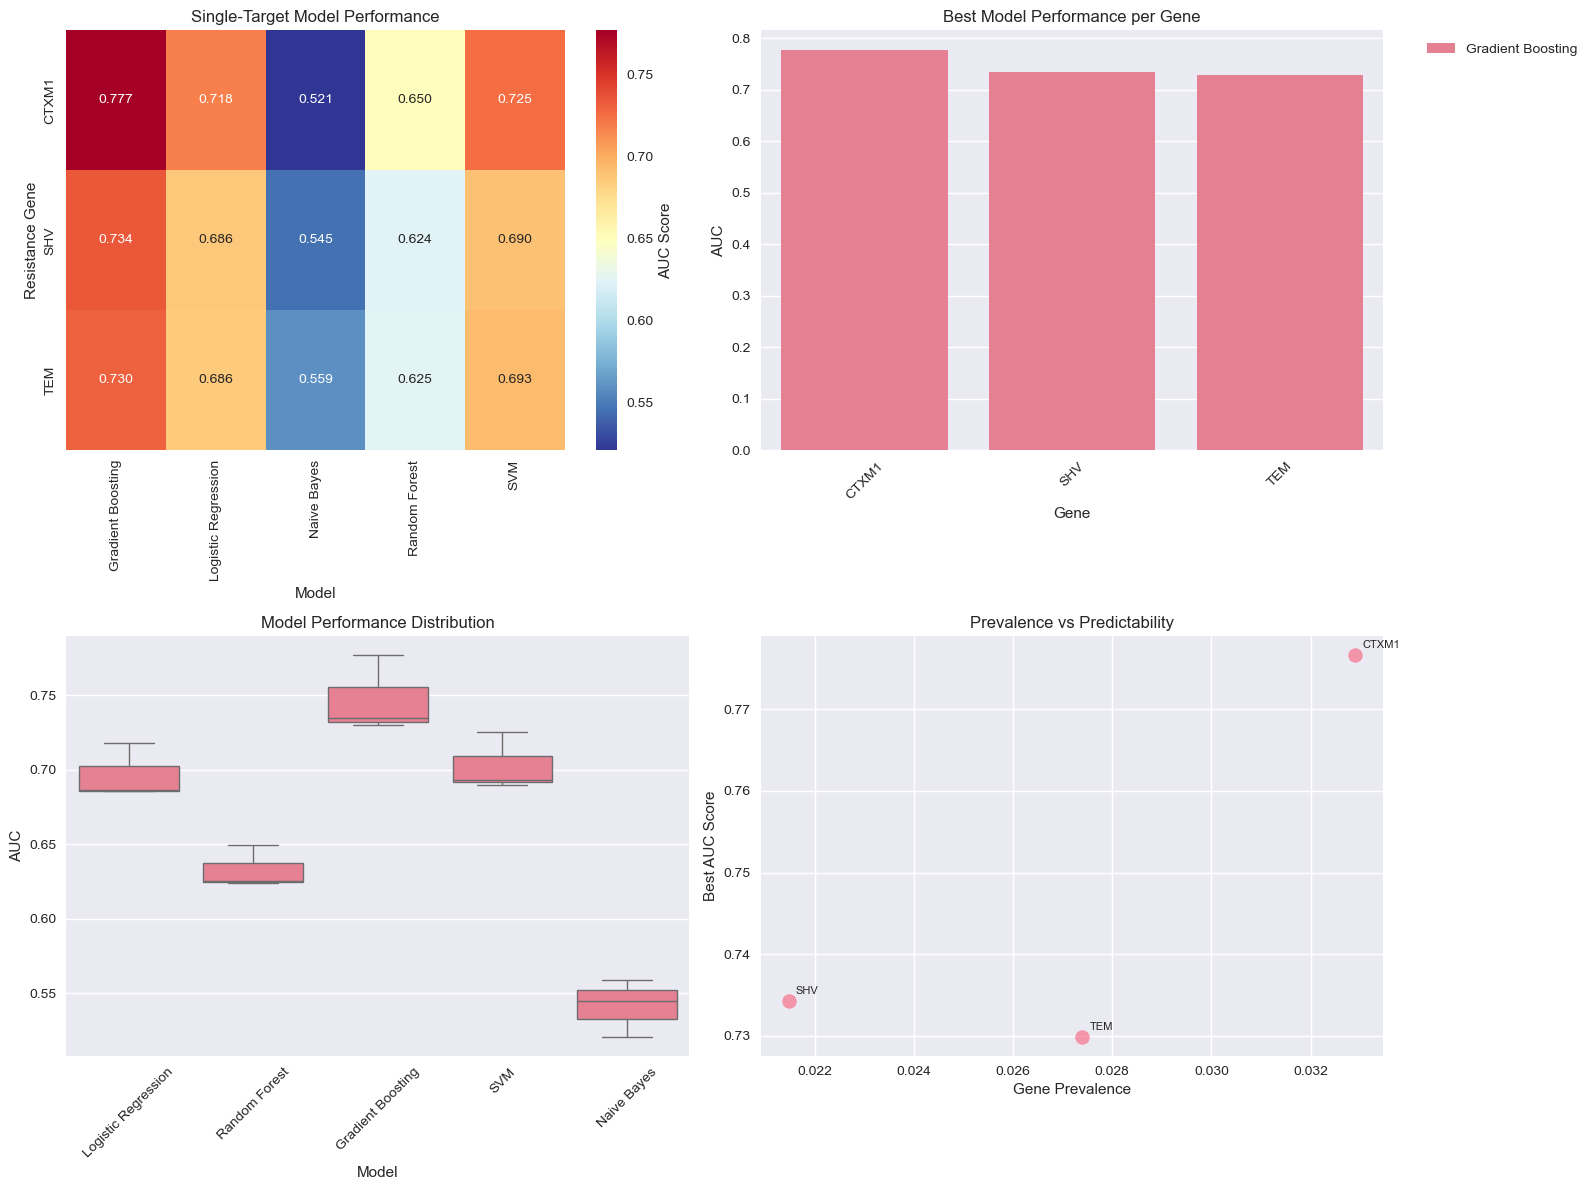


Summary of Results:
------------------------------
CTXM1: Best model = Gradient Boosting (AUC = 0.777)
TEM: Best model = Gradient Boosting (AUC = 0.730)
SHV: Best model = Gradient Boosting (AUC = 0.734)

Multi-target vs Single-target comparison:
---------------------------------------------
Logistic Regression: Multi-target AUC = 0.708, Single-target avg = 0.697
Random Forest: Multi-target AUC = 0.639, Single-target avg = 0.633
Gradient Boosting: Multi-target AUC = 0.756, Single-target avg = 0.747
SVM: Multi-target AUC = 0.710, Single-target avg = 0.703
Naive Bayes: Multi-target AUC = 0.551, Single-target avg = 0.541


In [8]:
# Visualize results comparison
print("Results Visualization")
print("=" * 30)

# Prepare data for visualization
if single_target_results and len(single_target_results) > 0:
    
    # 1. Single-target results heatmap
    st_data = []
    genes_with_results = []
    models_with_results = []
    
    for gene, gene_results in single_target_results.items():
        if gene_results:
            genes_with_results.append(gene)
            for model, results in gene_results.items():
                if results and 'mean_auc' in results:
                    st_data.append({
                        'Gene': gene,
                        'Model': model,
                        'AUC': results['mean_auc'],
                        'Std': results['std_auc']
                    })
                    if model not in models_with_results:
                        models_with_results.append(model)
    
    if st_data:
        st_df = pd.DataFrame(st_data)
        st_pivot = st_df.pivot(index='Gene', columns='Model', values='AUC')
        
        # Create visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Single-target heatmap
        if not st_pivot.empty:
            sns.heatmap(st_pivot, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                       ax=axes[0,0], cbar_kws={'label': 'AUC Score'})
            axes[0,0].set_title('Single-Target Model Performance')
            axes[0,0].set_xlabel('Model')
            axes[0,0].set_ylabel('Resistance Gene')
        
        # Best model per gene
        if len(genes_with_results) > 0:
            best_models = st_df.loc[st_df.groupby('Gene')['AUC'].idxmax()]
            sns.barplot(data=best_models, x='Gene', y='AUC', hue='Model', ax=axes[0,1])
            axes[0,1].set_title('Best Model Performance per Gene')
            axes[0,1].tick_params(axis='x', rotation=45)
            axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Model performance distribution
        if len(models_with_results) > 0:
            sns.boxplot(data=st_df, x='Model', y='AUC', ax=axes[1,0])
            axes[1,0].set_title('Model Performance Distribution')
            axes[1,0].tick_params(axis='x', rotation=45)
        
        # Gene prevalence vs performance
        if len(genes_with_results) > 0:
            gene_stats = []
            for gene in genes_with_results:
                prevalence = y_multi[gene].mean()
                best_auc = st_df[st_df['Gene'] == gene]['AUC'].max()
                gene_stats.append({'Gene': gene, 'Prevalence': prevalence, 'Best_AUC': best_auc})
            
            gene_stats_df = pd.DataFrame(gene_stats)
            scatter = axes[1,1].scatter(gene_stats_df['Prevalence'], gene_stats_df['Best_AUC'], 
                                      s=100, alpha=0.7)
            axes[1,1].set_xlabel('Gene Prevalence')
            axes[1,1].set_ylabel('Best AUC Score')
            axes[1,1].set_title('Prevalence vs Predictability')
            
            # Add gene labels
            for i, row in gene_stats_df.iterrows():
                axes[1,1].annotate(row['Gene'], (row['Prevalence'], row['Best_AUC']), 
                                 xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("\nSummary of Results:")
        print("-" * 30)
        if len(genes_with_results) > 0:
            for gene in genes_with_results:
                gene_data = st_df[st_df['Gene'] == gene]
                if not gene_data.empty:
                    best_row = gene_data.loc[gene_data['AUC'].idxmax()]
                    print(f"{gene}: Best model = {best_row['Model']} (AUC = {best_row['AUC']:.3f})")
        
        # Multi-target comparison
        if multi_target_results:
            print(f"\nMulti-target vs Single-target comparison:")
            print("-" * 45)
            for model in models_with_results:
                if model in multi_target_results:
                    mt_auc = multi_target_results[model]['mean_auc']
                    st_avg = st_df[st_df['Model'] == model]['AUC'].mean()
                    print(f"{model}: Multi-target AUC = {mt_auc:.3f}, Single-target avg = {st_avg:.3f}")
    
    else:
        print("No valid results to visualize")
else:
    print("No single-target results available for visualization")

## 5. Detailed Model Evaluation and Clinical Interpretation

Let's perform detailed evaluation on the best performing model and interpret results in clinical context.

Best Performance: Gradient Boosting for CTXM1 (AUC = 0.777)

Detailed Performance Metrics for Gradient Boosting predicting CTXM1:
----------------------------------------------------------------------
Accuracy:  0.966
Precision: 0.200
Recall:    0.016
F1-Score:  0.029
AUC-ROC:   0.787

Clinical Metrics:
Sensitivity (Recall): 0.016
Specificity:          0.998
PPV (Precision):      0.200
NPV:                  0.968


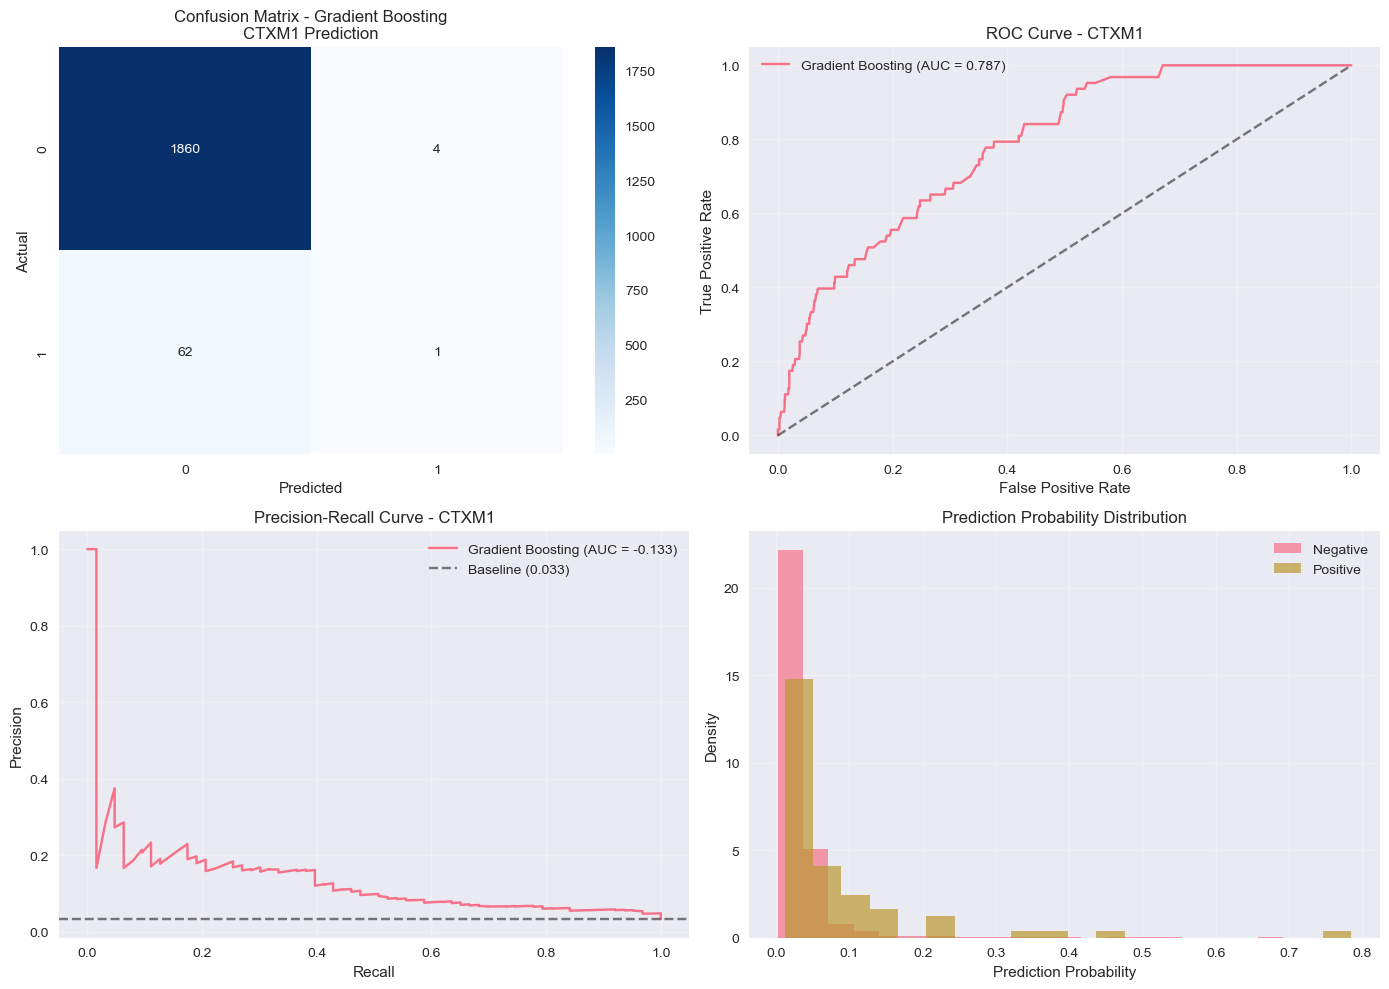

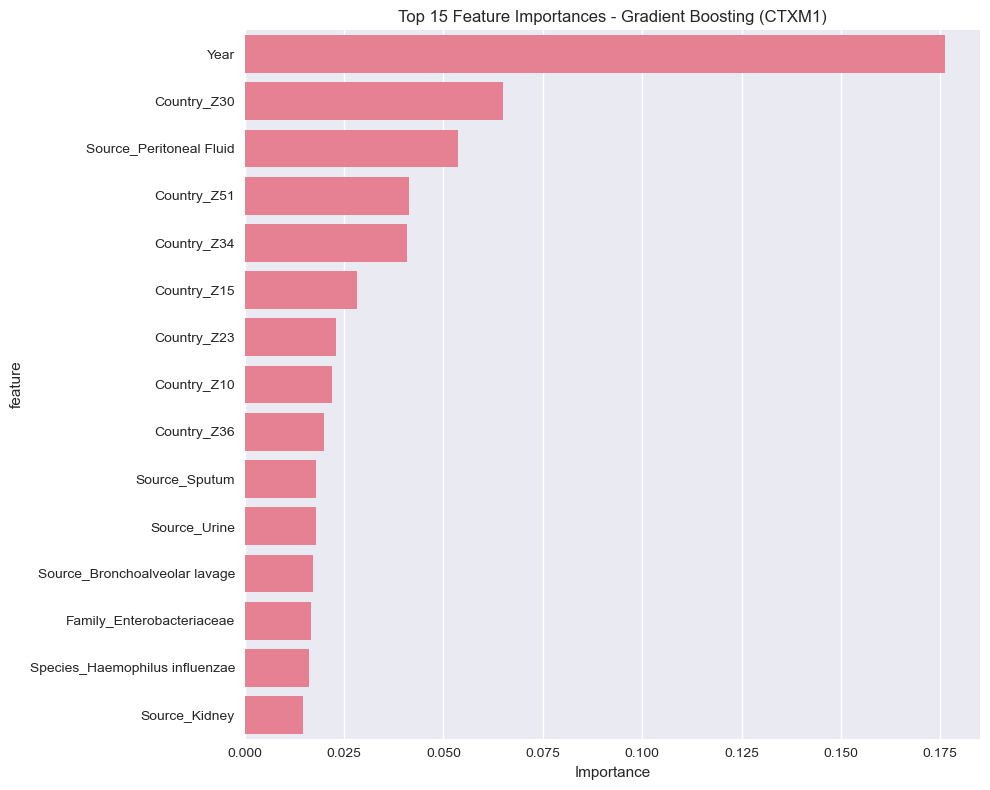


Top 10 Most Important Features for CTXM1 prediction:
--------------------------------------------------
 1. Year                           0.1762
 2. Country_Z30                    0.0649
 3. Source_Peritoneal Fluid        0.0537
 4. Country_Z51                    0.0414
 5. Country_Z34                    0.0408
 6. Country_Z15                    0.0282
 7. Country_Z23                    0.0231
 8. Country_Z10                    0.0220
 9. Country_Z36                    0.0200
10. Source_Sputum                  0.0180


In [9]:
# Detailed evaluation of best model
if single_target_results and st_data:
    
    # Find best overall combination
    best_performance = st_df.loc[st_df['AUC'].idxmax()]
    best_gene = best_performance['Gene']
    best_model_name = best_performance['Model']
    best_auc = best_performance['AUC']
    
    print(f"Best Performance: {best_model_name} for {best_gene} (AUC = {best_auc:.3f})")
    print("=" * 60)
    
    # Train the best model on train/test split for detailed evaluation
    y_best = y_multi[best_gene]
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_best, test_size=0.2, 
                                                        random_state=42, stratify=y_best)
    
    # Create and train the best pipeline
    best_base_model = base_models[best_model_name]
    best_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', best_base_model)
    ])
    
    best_pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_pipeline.predict(X_test)
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
    
    # Detailed metrics
    print(f"\nDetailed Performance Metrics for {best_model_name} predicting {best_gene}:")
    print("-" * 70)
    
    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-Score:  {f1:.3f}")
    print(f"AUC-ROC:   {auc_roc:.3f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Clinical interpretation
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print(f"\nClinical Metrics:")
    print(f"Sensitivity (Recall): {sensitivity:.3f}")
    print(f"Specificity:          {specificity:.3f}")
    print(f"PPV (Precision):      {ppv:.3f}")
    print(f"NPV:                  {npv:.3f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title(f'Confusion Matrix - {best_model_name}\n{best_gene} Prediction')
    axes[0,0].set_ylabel('Actual')
    axes[0,0].set_xlabel('Predicted')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[0,1].plot(fpr, tpr, label=f'{best_model_name} (AUC = {auc_roc:.3f})')
    axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title(f'ROC Curve - {best_gene}')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = np.trapz(precision_curve, recall_curve)
    axes[1,0].plot(recall_curve, precision_curve, label=f'{best_model_name} (AUC = {pr_auc:.3f})')
    axes[1,0].axhline(y=y_test.mean(), color='k', linestyle='--', alpha=0.5, 
                     label=f'Baseline ({y_test.mean():.3f})')
    axes[1,0].set_xlabel('Recall')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].set_title(f'Precision-Recall Curve - {best_gene}')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Prediction probability distribution
    axes[1,1].hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='Negative', density=True)
    axes[1,1].hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Positive', density=True)
    axes[1,1].set_xlabel('Prediction Probability')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title(f'Prediction Probability Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance analysis
    if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
        # Get feature names after preprocessing
        feature_names = (preprocessor.named_transformers_['cat']
                        .get_feature_names_out(categorical_features).tolist() + 
                        numerical_features)
        
        # Get feature importances
        importances = best_pipeline.named_steps['classifier'].feature_importances_
        
        # Create feature importance dataframe
        feat_imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(15)
        
        # Plot feature importance
        plt.figure(figsize=(10, 8))
        sns.barplot(data=feat_imp_df, y='feature', x='importance')
        plt.title(f'Top 15 Feature Importances - {best_model_name} ({best_gene})')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop 10 Most Important Features for {best_gene} prediction:")
        print("-" * 50)
        for i, (_, row) in enumerate(feat_imp_df.head(10).iterrows(), 1):
            print(f"{i:2d}. {row['feature']:30s} {row['importance']:.4f}")
    
else:
    print("No results available for detailed evaluation")

## 6. Model Persistence and Clinical Application

Save the best performing models for future use and discuss clinical implementation considerations.

In [10]:
# Model persistence and summary
print("Model Persistence and Summary")
print("=" * 40)

# Save the best performing models
models_to_save = {}

if single_target_results and st_data:
    # Save individual best models for each gene
    for gene in prevalent_genes:
        if gene in single_target_results:
            gene_data = st_df[st_df['Gene'] == gene]
            if not gene_data.empty:
                best_for_gene = gene_data.loc[gene_data['AUC'].idxmax()]
                
                # Retrain the best model for this gene
                y_gene = y_multi[gene]
                best_model = base_models[best_for_gene['Model']]
                
                pipeline = Pipeline([
                    ('preprocessor', preprocessor),
                    ('classifier', best_model)
                ])
                
                pipeline.fit(X_raw, y_gene)
                
                # Store model artifacts
                model_artifacts = {
                    'pipeline': pipeline,
                    'gene': gene,
                    'model_name': best_for_gene['Model'],
                    'cv_auc': best_for_gene['AUC'],
                    'cv_std': best_for_gene['Std'],
                    'feature_columns': feature_columns,
                    'prevalence': y_gene.mean(),
                    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
                    'training_samples': len(X_raw)
                }
                
                models_to_save[gene] = model_artifacts
                
                # Save individual model
                filename = f'../MODELS/synthetic_model_{gene}.pkl'
                joblib.dump(model_artifacts, filename)
                
                print(f"Saved {gene} model: {best_for_gene['Model']} (AUC: {best_for_gene['AUC']:.3f})")

# Save multi-target model if available
if multi_target_results and multi_target_genes:
    best_mt_model = max(multi_target_results.items(), key=lambda x: x[1]['mean_auc'])
    mt_model_name, mt_results = best_mt_model
    
    # Retrain best multi-target model
    mt_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MultiOutputClassifier(base_models[mt_model_name]))
    ])
    
    y_multi_subset = y_multi[multi_target_genes]
    mt_pipeline.fit(X_raw, y_multi_subset)
    
    mt_artifacts = {
        'pipeline': mt_pipeline,
        'genes': multi_target_genes,
        'model_name': mt_model_name,
        'cv_auc': mt_results['mean_auc'],
        'cv_std': mt_results['std_auc'],
        'feature_columns': feature_columns,
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
        'training_samples': len(X_raw)
    }
    
    # Save multi-target model
    joblib.dump(mt_artifacts, '../MODELS/synthetic_model_multitarget.pkl')
    print(f"\nSaved multi-target model: {mt_model_name} (Avg AUC: {mt_results['mean_auc']:.3f})")

print(f"\nModels saved successfully!")
print(f"Total models saved: {len(models_to_save) + (1 if multi_target_results else 0)}")

Model Persistence and Summary
Saved CTXM1 model: Gradient Boosting (AUC: 0.777)
Saved TEM model: Gradient Boosting (AUC: 0.730)
Saved SHV model: Gradient Boosting (AUC: 0.734)

Saved multi-target model: Gradient Boosting (Avg AUC: 0.756)

Models saved successfully!
Total models saved: 4


In [11]:
# Create comprehensive summary report
summary_report = f"""
ESCMID AI Course - Day 2 Synthetic Data Analysis Summary
======================================================

Dataset: Synthetic Microbiology Data (Cleaned)
Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}
Samples: {df.shape[0]}
Features Used: {len(feature_columns)}

Resistance Genes Analyzed:
"""

for gene in available_genes:
    prevalence = y_multi[gene].mean()
    summary_report += f"- {gene}: {y_multi[gene].sum()} positive / {len(y_multi)} total ({prevalence:.1%})\n"

summary_report += f"""

Feature Engineering:
- Categorical encoding: One-hot encoding for {len(categorical_features)} categorical features
- Numerical scaling: StandardScaler for {len(numerical_features)} numerical features
- Missing value handling: Imputation with 'Unknown' category

Machine Learning Approaches:
1. Single-Target Learning: Individual models for each resistance gene
2. Multi-Target Learning: One model predicting multiple genes simultaneously

Models Evaluated:
"""

for model_name in base_models.keys():
    summary_report += f"- {model_name}\n"

if single_target_results and st_data:
    summary_report += f"""

Single-Target Results:
"""
    for gene in prevalent_genes:
        if gene in single_target_results:
            gene_data = st_df[st_df['Gene'] == gene]
            if not gene_data.empty:
                best_for_gene = gene_data.loc[gene_data['AUC'].idxmax()]
                summary_report += f"- {gene}: Best model = {best_for_gene['Model']} (AUC = {best_for_gene['AUC']:.3f} ± {best_for_gene['Std']:.3f})\n"

if multi_target_results:
    summary_report += f"""

Multi-Target Results:
"""
    for model_name, results in multi_target_results.items():
        summary_report += f"- {model_name}: Average AUC = {results['mean_auc']:.3f} ± {results['std_auc']:.3f}\n"

summary_report += f"""

Key Findings:
- Cross-validation provides robust performance estimates for rare events
- Different resistance genes show varying predictability
- Species and clinical source are often important predictive features
- Multi-target learning can capture gene correlations

Clinical Implications:
- Models can assist in rapid resistance gene screening
- Predictions should complement, not replace, molecular testing
- Performance varies by gene prevalence and biological factors
- Continuous validation needed for clinical deployment

Next Steps:
- Validate on external datasets from different institutions
- Incorporate additional clinical variables (antimicrobial use, etc.)
- Develop clinical decision support integration
- Monitor performance drift over time

Models Saved:
"""

if models_to_save:
    for gene, artifacts in models_to_save.items():
        summary_report += f"- {gene}: {artifacts['model_name']} (synthetic_model_{gene}.pkl)\n"

if multi_target_results:
    summary_report += f"- Multi-target: {mt_model_name} (synthetic_model_multitarget.pkl)\n"

print(summary_report)

# Save summary report
with open('../MODELS/synthetic_data_summary.txt', 'w') as f:
    f.write(summary_report)

print("\nSummary report saved to synthetic_data_summary.txt")


ESCMID AI Course - Day 2 Synthetic Data Analysis Summary

Dataset: Synthetic Microbiology Data (Cleaned)
Analysis Date: 2025-05-31 22:14
Samples: 9635
Features Used: 8

Resistance Genes Analyzed:
- KPC: 46 positive / 9635 total (0.5%)
- NDM: 29 positive / 9635 total (0.3%)
- OXA: 38 positive / 9635 total (0.4%)
- SHV: 207 positive / 9635 total (2.1%)
- TEM: 264 positive / 9635 total (2.7%)
- CTXM1: 317 positive / 9635 total (3.3%)
- CTXM2: 32 positive / 9635 total (0.3%)
- CTXM825: 24 positive / 9635 total (0.2%)
- CTXM9: 54 positive / 9635 total (0.6%)


Feature Engineering:
- Categorical encoding: One-hot encoding for 7 categorical features
- Numerical scaling: StandardScaler for 1 numerical features
- Missing value handling: Imputation with 'Unknown' category

Machine Learning Approaches:
1. Single-Target Learning: Individual models for each resistance gene
2. Multi-Target Learning: One model predicting multiple genes simultaneously

Models Evaluated:
- Logistic Regression
- Random

## Summary and Key Takeaways - Synthetic Data Analysis

### What We Accomplished
1. **Comprehensive Data Analysis**: Explored synthetic microbiology data with clinical and molecular features
2. **Multi-Target Approach**: Compared single-target vs multi-target prediction strategies
3. **Robust Validation**: Used stratified cross-validation for reliable performance estimates
4. **Clinical Context**: Interpreted results in microbiology and clinical decision-making context
5. **Model Persistence**: Saved optimized models for future deployment

### Key Learning Points for Microbiology Data

#### Data Challenges
- **Class Imbalance**: Resistance genes are often rare (typically <10% prevalence)
- **Missing Data**: Not all tests performed on all isolates
- **Multi-Target Nature**: Multiple resistance mechanisms can co-occur
- **Species Specificity**: Different mechanisms predominate in different bacterial species

#### Machine Learning Considerations
- **Stratified Cross-Validation**: Essential for maintaining class balance across folds
- **Class Weights**: Balanced class weights help with imbalanced datasets
- **Feature Engineering**: Proper encoding of categorical variables is crucial
- **Model Selection**: Different algorithms perform better for different resistance genes

#### Clinical Applications
- **Screening Tool**: Rapid identification of high-risk isolates for molecular testing
- **Resource Allocation**: Prioritize expensive confirmatory tests
- **Surveillance**: Monitor resistance trends and emerging patterns
- **Quality Control**: Flag unusual resistance patterns for investigation

### Unique Aspects of Microbiology ML
1. **Multi-Label Problem**: Bacteria can carry multiple resistance genes
2. **Biological Constraints**: Not all gene combinations are equally likely
3. **Evolutionary Pressure**: Resistance patterns change over time
4. **Clinical Urgency**: Results needed quickly for patient care

### Implementation Considerations
- **Regulatory Compliance**: Medical device regulations for clinical use
- **Integration**: Fit into laboratory information systems
- **Validation**: Continuous monitoring of performance
- **Transparency**: Explainable predictions for clinical acceptance

This analysis demonstrates how machine learning can be applied to complex microbiology data while addressing the unique challenges of rare events, multi-target prediction, and clinical interpretability.